In [4]:
#pip install ruptures

Note: you may need to restart the kernel to use updated packages.


In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display

import ruptures as rpt  # our package

In [35]:
def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

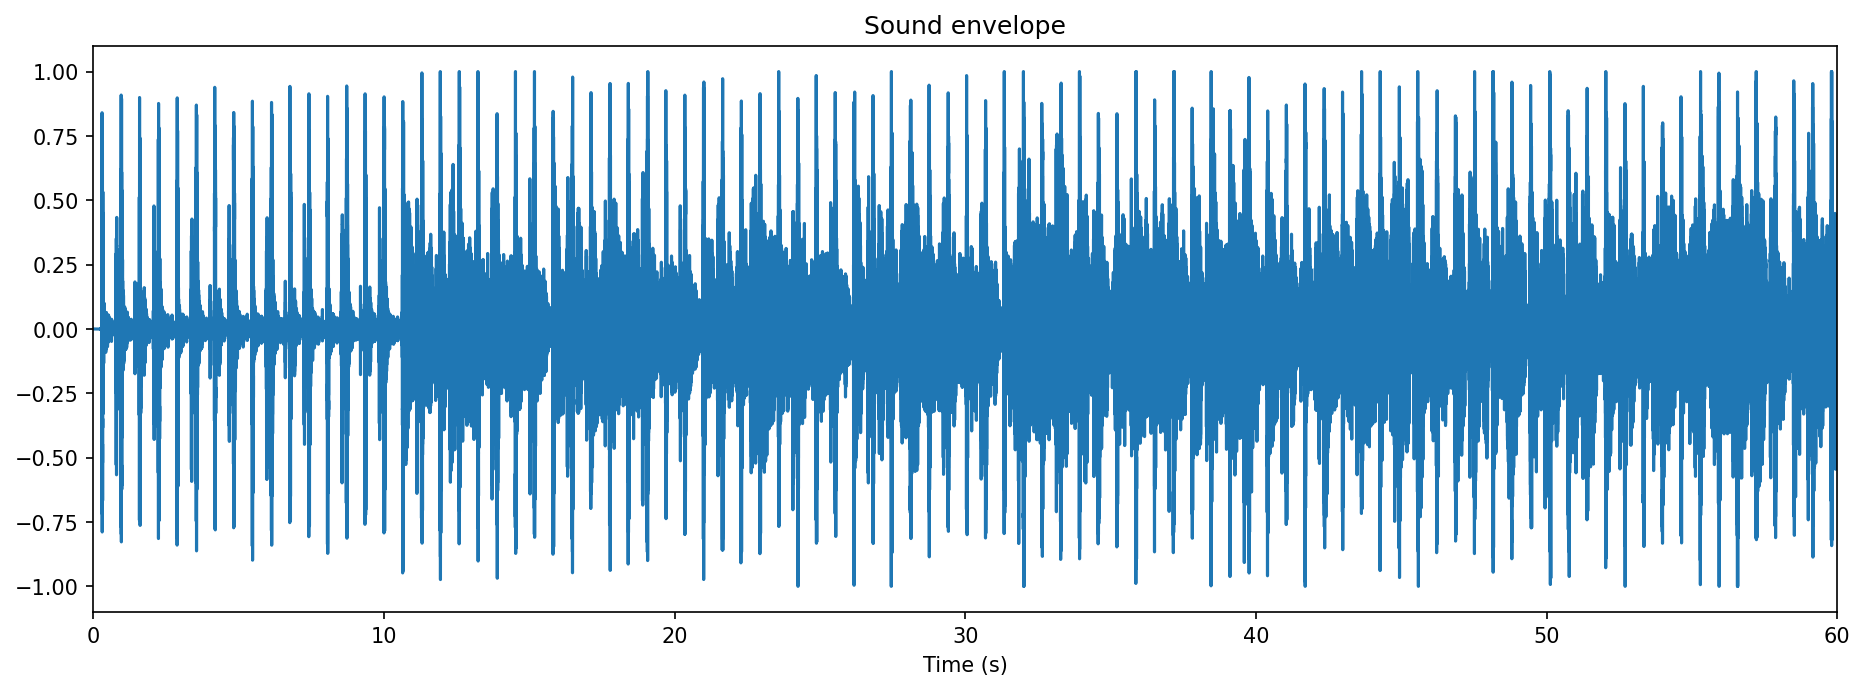

In [36]:
duration = 60  # in seconds
#signal, sampling_rate = librosa.load(('recording1.wav'), duration=duration)
signal, sampling_rate = librosa.load(('audio/africa-toto.wav'), duration=duration)


# listen to the music
display(Audio(data=signal, rate=sampling_rate))

# look at the envelope
fig, ax = fig_ax()
ax.plot(np.arange(signal.size) / sampling_rate, signal)
ax.set_xlim(0, signal.size / sampling_rate)
ax.set_xlabel("Time (s)")
_ = ax.set(title="Sound envelope")

C:\Users\AlexW\Anaconda3\lib\site-packages\librosa\display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


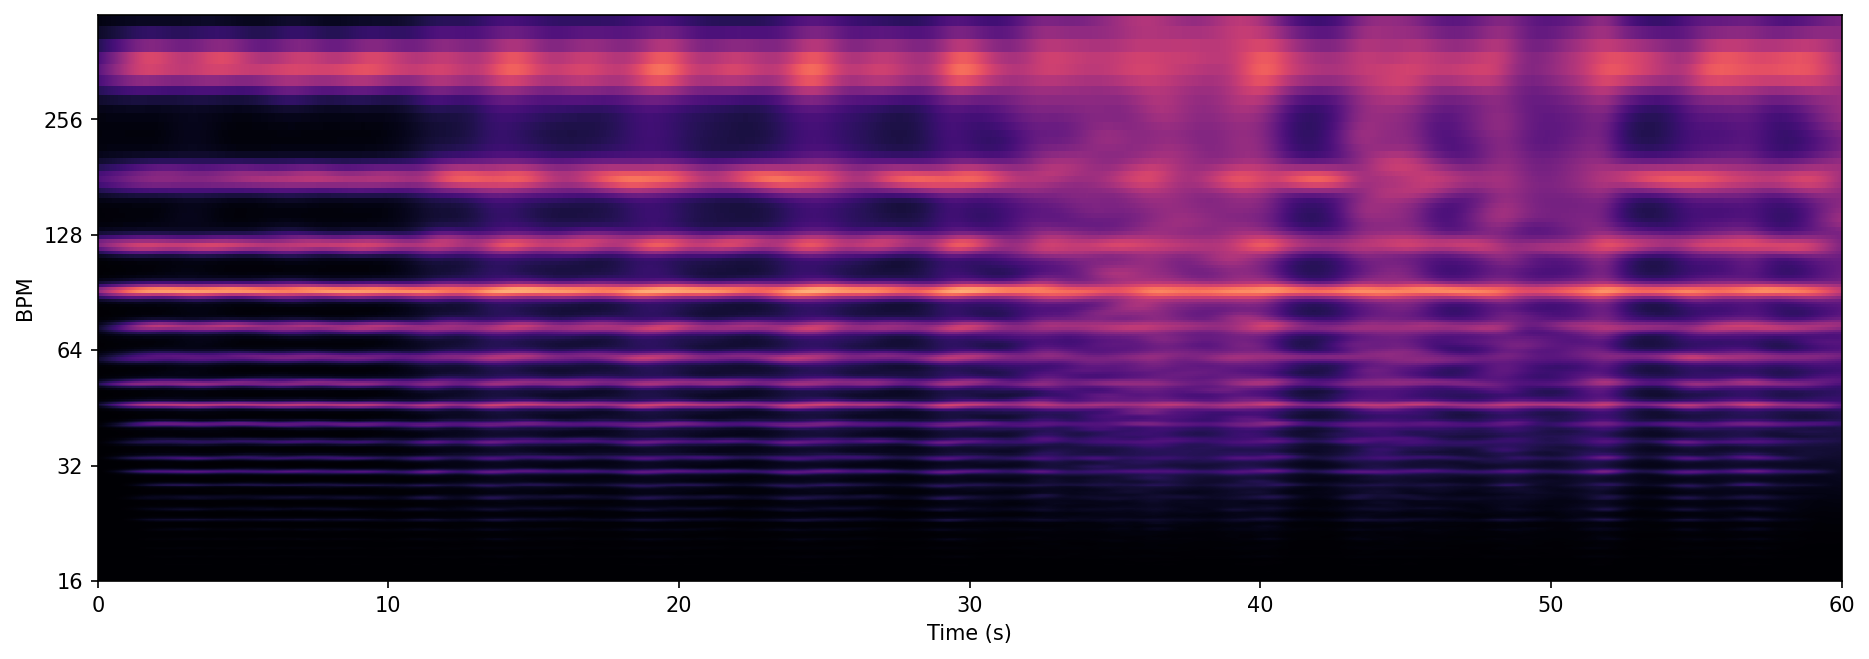

In [37]:
# Compute the onset strength
hop_length_tempo = 256
oenv = librosa.onset.onset_strength(
    y=signal, sr=sampling_rate, hop_length=hop_length_tempo
)
# Compute the tempogram
tempogram = librosa.feature.tempogram(
    onset_envelope=oenv,
    sr=sampling_rate,
    hop_length=hop_length_tempo,
)
# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sampling_rate,
    x_axis="s",
    y_axis="tempo",
)

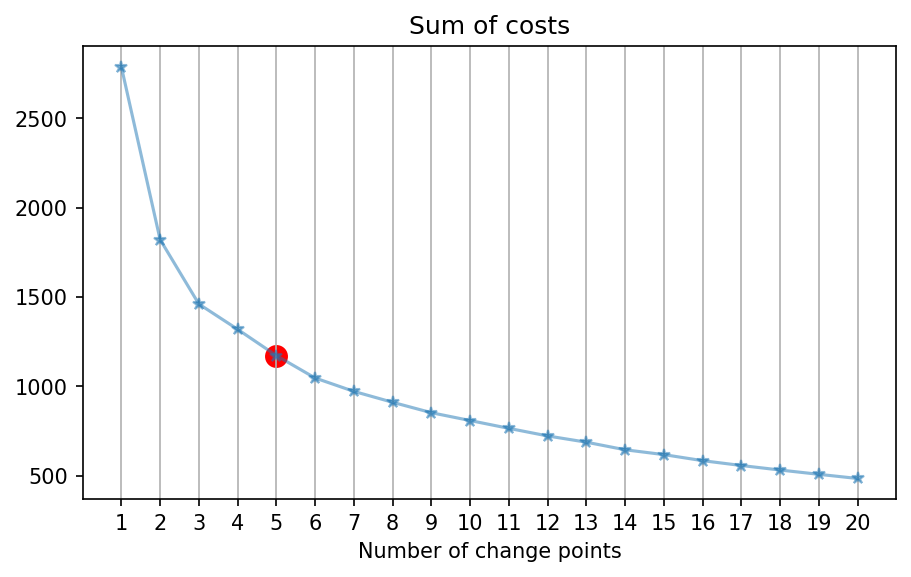

In [41]:
# Choose detection method
algo = rpt.KernelCPD(kernel="linear").fit(tempogram.T)

# Choose the number of changes (elbow heuristic)
n_bkps_max = 20  # K_max
# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
_ = algo.predict(n_bkps_max)

array_of_n_bkps = np.arange(1, n_bkps_max + 1)


def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)


fig, ax = fig_ax((7, 4))
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
ax.set_xticks(array_of_n_bkps)
ax.set_xlabel("Number of change points")
ax.set_title("Sum of costs")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max + 1)

# Visually we choose n_bkps=5 (highlighted in red on the elbow plot)
n_bkps = 5
_ = ax.scatter([5], [get_sum_of_cost(algo=algo, n_bkps=5)], color="r", s=100)

[11.28489796 32.04353741 40.58848073 60.00036281]


C:\Users\AlexW\Anaconda3\lib\site-packages\librosa\display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


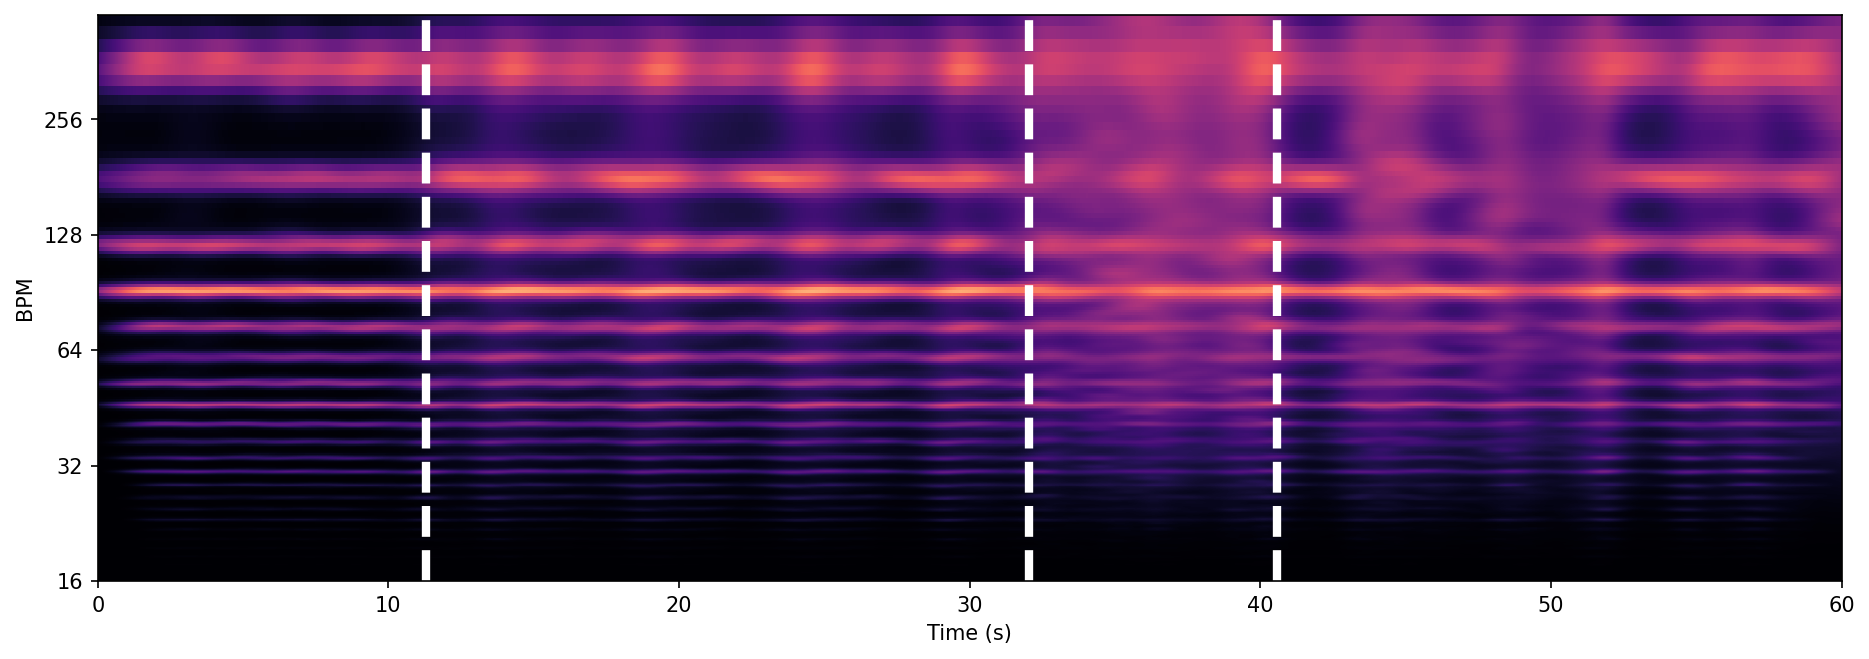

In [42]:
n_bkps = 3
# Segmentation
bkps = algo.predict(n_bkps=n_bkps)
# Convert the estimated change points (frame counts) to actual timestamps
bkps_times = librosa.frames_to_time(bkps, sr=sampling_rate, hop_length=hop_length_tempo)
print(bkps_times) #this corresponds to the changes

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sampling_rate,
)

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

In [43]:
# Compute change points corresponding indexes in original signal
bkps_time_indexes = (sampling_rate * bkps_times).astype(int).tolist()

for (segment_number, (start, end)) in enumerate(
    rpt.utils.pairwise([0] + bkps_time_indexes), start=1
):
    segment = signal[start:end]
    print(f"Segment n°{segment_number} (duration: {segment.size/sampling_rate:.2f} s)")
    display(Audio(data=segment, rate=sampling_rate))

Segment n°1 (duration: 11.28 s)


Segment n°2 (duration: 20.76 s)


Segment n°3 (duration: 8.54 s)


Segment n°4 (duration: 19.41 s)
